## Install deps

In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn

## Imports

In [2]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

## Load dataset

In [3]:
dataframe = read_csv("clear_all_data.csv", index_col=0)
dataframe.head()

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district_Академический,...,underground_Шоссе Энтузиастов,underground_Щербинка,underground_Щукинская,underground_Щёлковская,underground_Электрозаводская,underground_Юго-Восточная,underground_Юго-Западная,underground_Южная,underground_Ясенево,underground_Яхромская
1,17,41,1,40.4,618811,25000000,2021,15.2,9.1,False,...,False,False,False,False,False,False,False,False,False,False
3,9,41,1,40.5,617283,25000000,2022,17.3,9.3,False,...,False,False,False,False,False,False,False,False,False,False
5,6,13,1,71.1,983122,69900000,2019,37.1,12.8,False,...,False,False,False,False,False,False,False,False,False,False
7,33,36,1,75.0,626666,47000000,2020,35.0,20.0,False,...,False,False,False,False,False,False,False,False,False,False
9,6,41,1,41.0,724390,29700000,2022,24.0,6.0,False,...,False,False,False,False,False,False,False,False,False,False


## Define args and y

In [4]:
X = dataframe.drop("price_per_m2", axis=1)
y = dataframe.price_per_m2


In [5]:
X.shape

(4233, 1314)

In [6]:
y.shape

(4233,)

## Split to train and test dataframes

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Define and train models

In [8]:
model_list = []

### Lasso regression

* ### Create CV for lasso regression model

In [9]:
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=5)

* ### Learn model

In [10]:
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(cv=cv, n_jobs=-1, max_iter=10000)
lasso_model.fit(X_train, y_train)
model_list.append(lasso_model)

### Linear regression

In [11]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
model_list.append(linear_model)

### ElasticNET

In [12]:
from sklearn.linear_model import ElasticNetCV
elastic_model = ElasticNetCV(cv=cv, n_jobs=-1, max_iter=10000)
elastic_model.fit(X_train, y_train)
model_list.append(elastic_model)

### Ridge

In [13]:
from sklearn.linear_model import RidgeCV
ridge_model = RidgeCV(cv=cv)
ridge_model.fit(X_train,y_train)
model_list.append(ridge_model)

c:\Users\aduny\Projects\ml\machine_learning\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.63418e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\aduny\Projects\ml\machine_learning\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.38708e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\aduny\Projects\ml\machine_learning\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24932e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\aduny\Projects\ml\machine_learning\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.50594e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Make prediction

In [14]:
predict_list = []

for model in model_list:
    predict_list.append(model.predict(X_test))

## Plot of data

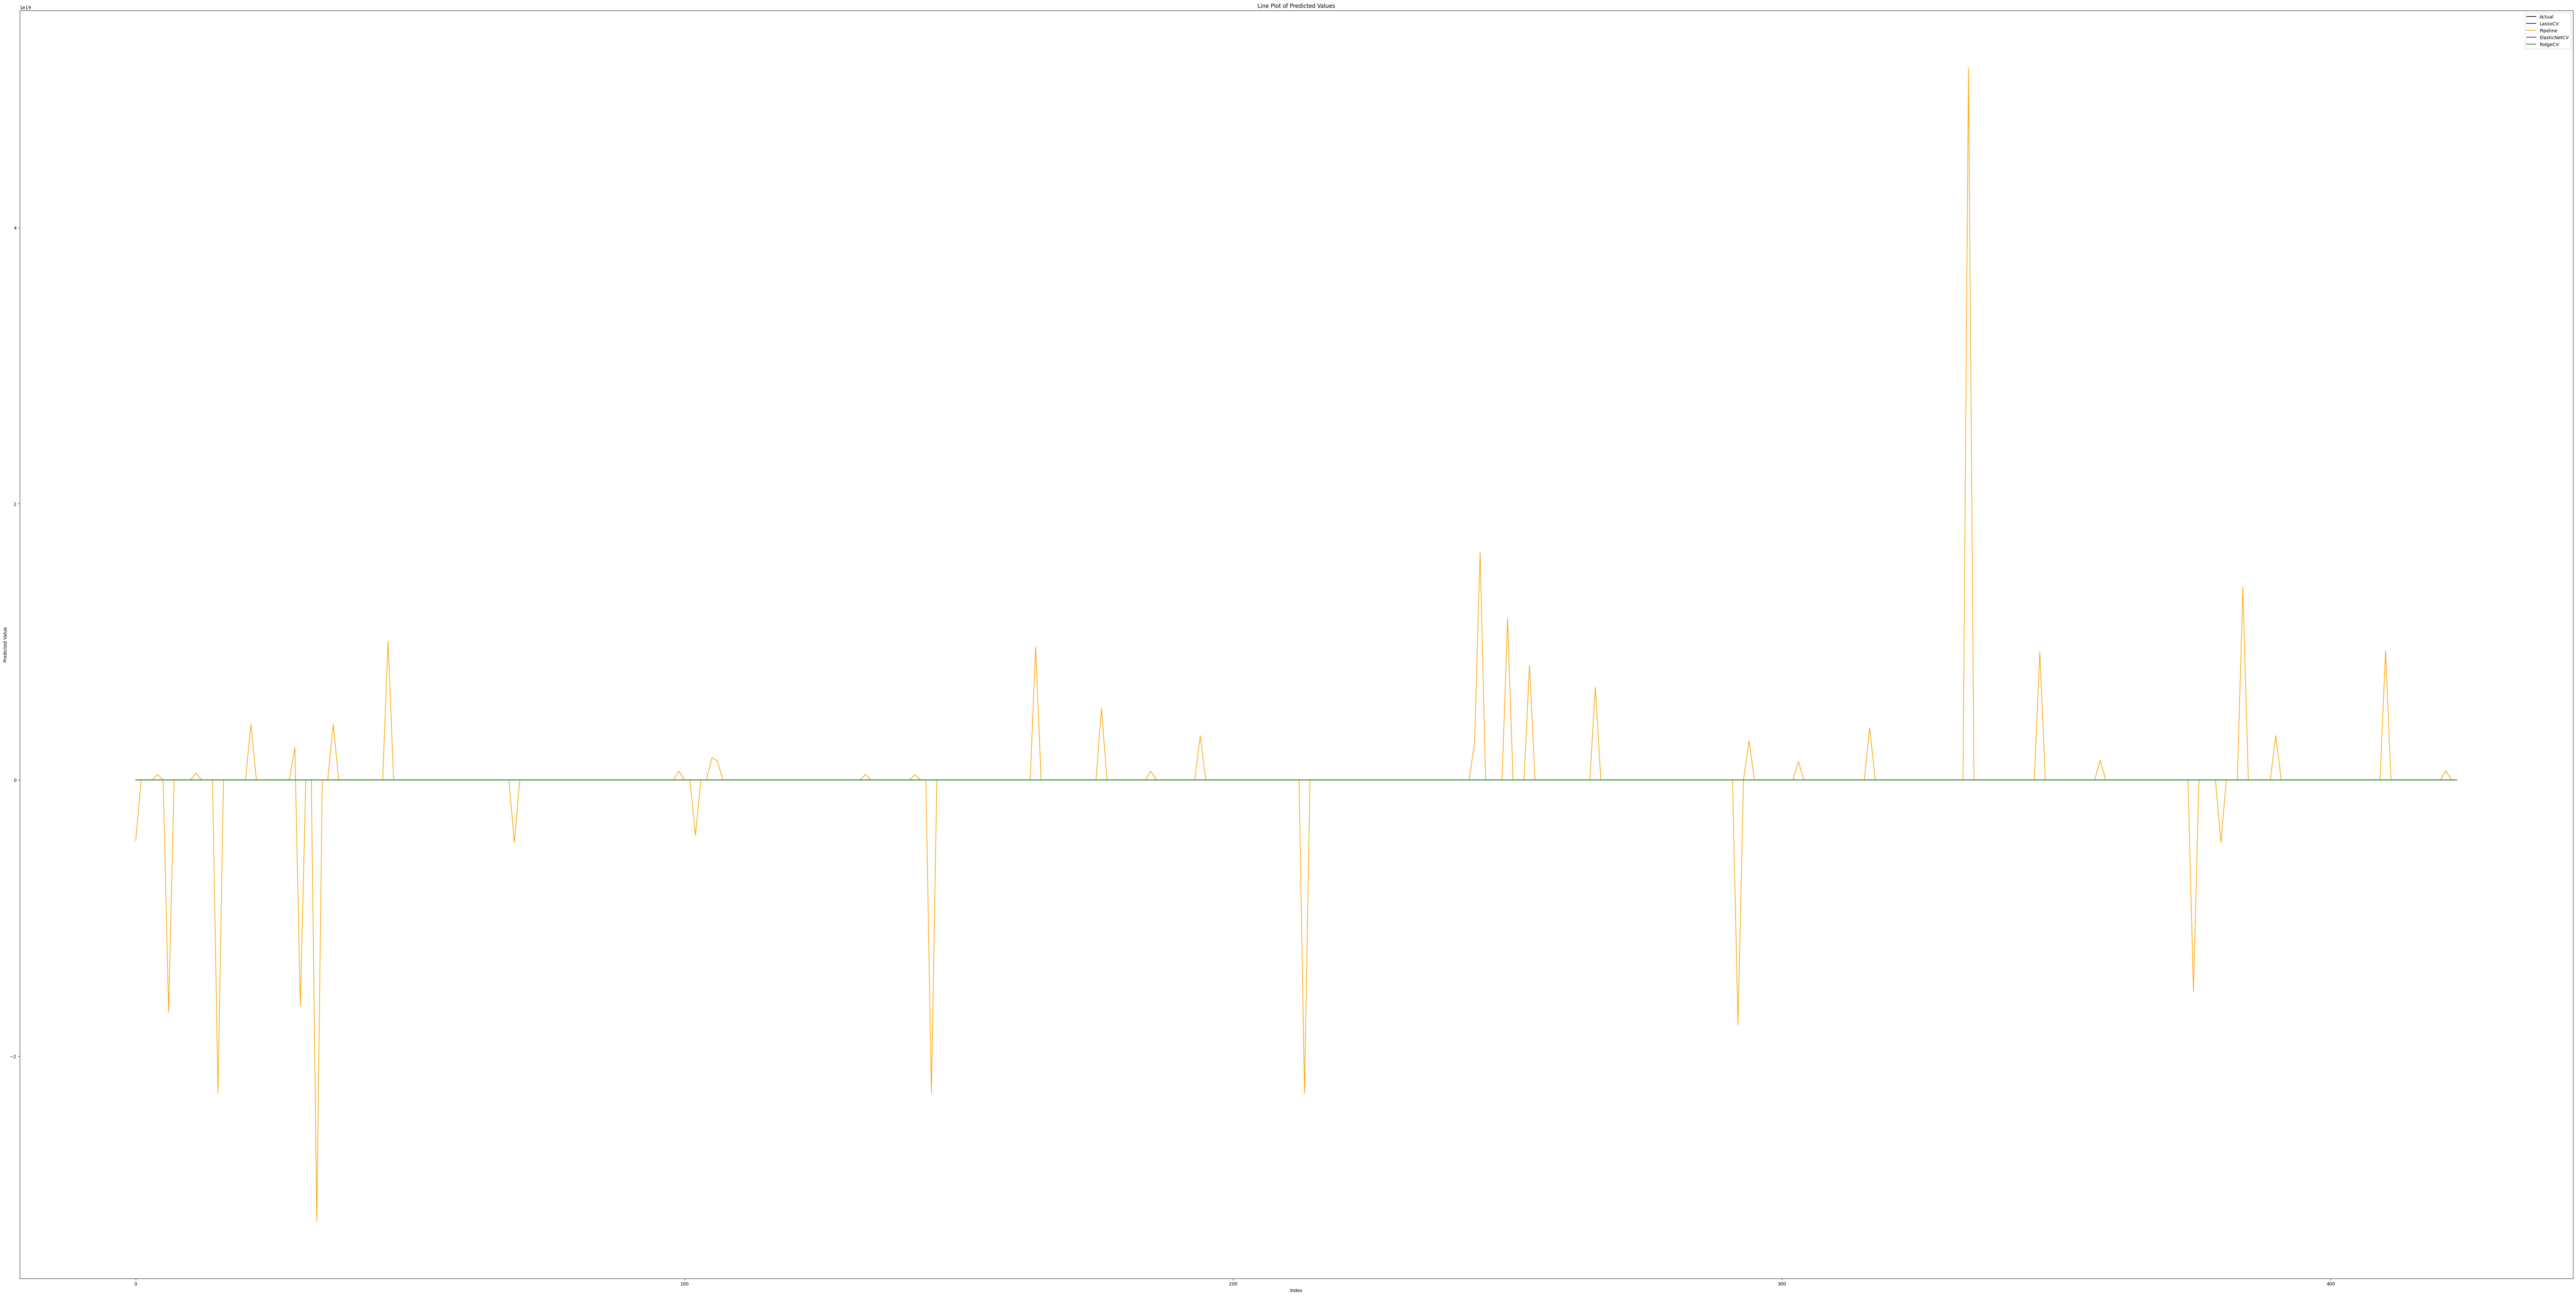

In [15]:
from matplotlib import pyplot as plt
from matplotlib import colors
import pandas as pd
import seaborn as sns

ALL_COLORS = ["blue","orange","purple","green","white","gray"]

plt.figure(figsize=(100, 50))
sns.lineplot(x=range(len(y_test)), y=y_test, color='black', label='Actual')
plt.xlabel('Index')
plt.ylabel('Predicted Value')
plt.title('Line Plot of Predicted Values')

for i in range(0, len(model_list)):
    sns.lineplot(x=range(len(predict_list[i])), y=predict_list[i], color=ALL_COLORS[i], label=type(model_list[i]).__name__)

plt.show()

## Check score of model

In [16]:
print("Scores: ")
for i, model in enumerate(model_list):
    print(f"\n* {type(model_list[i]).__name__}: {model.score(X_test, y_test)*100:.2f}%\t")

Scores: 

* LassoCV: 64.19%	

* Pipeline: -30265493052580023536871014400.00%	

* ElasticNetCV: 64.15%	

* RidgeCV: 90.53%	


## Mean errors

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Absolute

In [18]:
print("MAE (Mean Absolute Error): ")
for i, predict in enumerate(predict_list):
    mse = mean_absolute_error(y_true=y_test, y_pred=predict)
    print(f"\n* {type(model_list[i]).__name__}: {mse:.2f}\t")

MAE (Mean Absolute Error): 

* LassoCV: 102468.31	

* Pipeline: 875371166342741888.00	

* ElasticNetCV: 102464.74	

* RidgeCV: 49752.53	


### Squared

In [19]:
print("MSE (Mean Squared Error): ")
for i, predict in enumerate(predict_list):
    print(f"\n* {type(model_list[i]).__name__}: {mean_squared_error(y_test, predict):.2f}\t")


MSE (Mean Squared Error): 

* LassoCV: 21217670953.38	

* Pipeline: 17930026941806982709014182829198671872.00	

* ElasticNetCV: 21238141727.40	

* RidgeCV: 5611996516.08	
